# BMTF input stubs fit with a Deep Learning approach

## Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

2024-07-08 14:57:11.792456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 14:57:11.792503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 14:57:11.793532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 14:57:11.800401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# hep.style.use("CMS")

warnings.filterwarnings("ignore")

# mpl.rcParams["figure.dpi"] = 300

In [3]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Constants

In [5]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit/"

FILE_NAME = "rereco"

OUT_PATH = "Plots/"
LOSS_FNAME = "losses.csv"

# FIGSIZE = (12, 9)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

## Classes

### Neural Network model for regression+classification task

In [6]:
class MultiTaskNN(tf.keras.Model):
    def __init__(self, architecture, reg_strength=0.01):
        super(MultiTaskNN, self).__init__()

        # Check if the architecture list has at least 2 values (input size and one hidden layer)
        if len(architecture) < 2:
            raise ValueError("Architecture must contain at least input size and one hidden layer.")

        self.layers_list = []

        # Iterate over the architecture list to dynamically create dense layers followed by batch normalization
        for i in range(1, len(architecture)):
            self.layers_list.append(layers.Dense(architecture[i], kernel_regularizer=regularizers.l2(reg_strength)))
            self.layers_list.append(layers.Activation('elu'))

            # TODO: It looks like there might be a typo in the comment.
            #  The code does not currently include a batch normalization layer after each dense layer.
            #  It only has dense layers followed by activation layers.

        # Separate heads for regression and classification tasks
        self.regression_head = layers.Dense(3, kernel_regularizer=regularizers.l2(reg_strength))  # for pt, eta, phi
        self.classification_head = layers.Dense(1, kernel_regularizer=regularizers.l2(reg_strength))  # for charge
        # self.classification_head = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(reg_strength))  # for charge

    #forward pass of the neural network.
    def call(self, inputs):
        x = inputs
        # Where all the multiplications are done
        for layer in self.layers_list:
            x = layer(x)

        reg_output = self.regression_head(x)
        class_output = self.classification_head(x)
        return reg_output, class_output

### Custom Learning Rate scheduler

This callback is designed to adjust the learning rate of the optimizer during training based on the validation loss.\
It adjusts the learning rate based on the validation loss, reducing it if the loss does not improve sufficiently over a number of epochs (patience).

In [7]:
# Custom learning rate scheduler callback
class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, 
        optimizer, 
        factor=0.5, 
        patience=5, 
        min_improvement=0.01, 
        verbose=True
    ):
        super(CustomLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_improvement = min_improvement
        self.verbose = verbose
        self.best_loss = float('inf')
        self.patience_counter = 0

        
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.optimizer.lr.assign(self.min_lr)
        if epoch < self.decrease_epoch:
            self.increase_flag = True
        else:
            self.increase_flag = False


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("val_loss")

        if loss:
            relative_improvement = (self.best_loss - loss) / self.best_loss

            if relative_improvement < self.min_improvement:
                self.patience_counter += 1
            else:
                self.patience_counter = 0
                self.best_loss = loss

            if self.patience_counter >= self.patience:
                self._decrease_lr()

    def _decrease_lr(self):
        old_lr = self.optimizer.lr.numpy()
        new_lr = old_lr * self.factor
        self.optimizer.lr.assign(new_lr)
        if self.verbose:
            print(f"Decreasing learning rate to {new_lr}")

## Normalizations

In [8]:
n_stubs_norm         = 2**2
station_norm         = 2**2
sector_norm          = 2**3
wheel_norm           = 2**1
eta_norm             = 2**8
qeta_norm            = 2**1
tag_norm             = 2**0
phi_norm             = 2**11
phib_norm            = 2**9
quality_norm         = 2**3
reco_pt_norm         = 2**0
reco_pt_inverse_norm = 2**0
reco_eta_norm        = 2**2
reco_phi_norm        = 2**2
reco_charge_norm     = 2**0

normalizations = {
    "n_stubs": n_stubs_norm,
    "s1_stNum": station_norm,
    "s1_scNum": sector_norm,
    "s1_whNum": wheel_norm,
    "s1_eta_1": eta_norm,
    "s1_qeta_1": qeta_norm,
    "s1_eta_2": eta_norm,
    "s1_qeta_2": qeta_norm,
    "s1_tag": tag_norm,
    "s1_phi": phi_norm,
    "s1_phiB": phib_norm,
    "s1_quality": quality_norm,
    "s2_stNum": station_norm,
    "s2_scNum": sector_norm,
    "s2_whNum": wheel_norm,
    "s2_eta_1": eta_norm,
    "s2_qeta_1": qeta_norm,
    "s2_eta_2": eta_norm,
    "s2_qeta_2": qeta_norm,
    "s2_tag": tag_norm,
    "s2_phi": phi_norm,
    "s2_phiB": phib_norm,
    "s2_quality": quality_norm,
    "s3_stNum": station_norm,
    "s3_scNum": sector_norm,
    "s3_whNum": wheel_norm,
    "s3_eta_1": eta_norm,
    "s3_qeta_1": qeta_norm,
    "s3_eta_2": eta_norm,
    "s3_qeta_2": qeta_norm,
    "s3_tag": tag_norm,
    "s3_phi": phi_norm,
    "s3_phiB": phib_norm,
    "s3_quality": quality_norm,
    "s4_stNum": station_norm,
    "s4_scNum": sector_norm,
    "s4_whNum": wheel_norm,
    "s4_eta_1": eta_norm,
    "s4_qeta_1": qeta_norm,
    "s4_eta_2": eta_norm,
    "s4_qeta_2": qeta_norm,
    "s4_tag": tag_norm,
    "s4_phi": phi_norm,
    "s4_phiB": phib_norm,
    "s4_quality": quality_norm,
    # "ptReco": reco_pt_norm,
    "ptRecoInverse": reco_pt_inverse_norm,
    "etaExtRecoSt2": reco_eta_norm,
    "phiExtRecoSt2": reco_phi_norm,
    "chargeReco": reco_charge_norm,
}


## Features 

| Feature                  | Description                                                                                  |
|--------------------------|----------------------------------------------------------------------------------------------|
| **n_stubs**              | The total number of stubs detected for a muon.                                               |
| **s1_stNum, s2_stNum, s3_stNum, s4_stNum** | The specific muon station where the stub was detected.                            |
| **s1_scNum, s2_scNum, s3_scNum, s4_scNum** | The sector within the muon station where the stub was detected.                       |
| **s1_whNum, s2_whNum, s3_whNum, s4_whNum** | The wheel of the muon detector where the stub was detected.                          |
| **s1_eta_1, s2_eta_1, s3_eta_1, s4_eta_1, s1_eta_2, s2_eta_2, s3_eta_2, s4_eta_2** | The pseudorapidity of the stub.                                                       |
| **s1_qeta_1, s2_qeta_1, s3_qeta_1, s4_qeta_1, s1_qeta_2, s2_qeta_2, s3_qeta_2, s4_qeta_2** |----- ----                                            |
| **s1_tag, s2_tag, s3_tag, s4_tag** | A tag indicating specific characteristics of the stub.                                  |
| **s1_phi, s2_phi, s3_phi, s4_phi** | The azimuthal angle of the stub.                                                          |
| **s1_phiB, s2_phiB, s3_phiB, s4_phiB** | The bending angle of the stub in the phi plane.                                           |
| **s1_quality, s2_quality, s3_quality, s4_quality** | A quality metric for the stub.                                                           |
| **ptReco, ptRecoInverse** | The transverse momentum of the muon, reconstructed from the stubs.                              |
| **etaExtRecoSt2** | The reconstructed pseudorapidity of the muon from the stubs.                                   |
| **phiExtRecoSt2** | The reconstructed azimuthal angle of the muon from the stubs.                                      |
| **chargeReco** | The reconstructed charge of the muon from the stubs.                                               |

In [9]:
stub_features = [
    'n_stubs', 
    's1_stNum', 's1_scNum', 's1_whNum', 's1_eta_1', 's1_qeta_1', 's1_eta_2', 's1_qeta_2', 's1_tag', 's1_phi', 's1_phiB', 's1_quality', 
    's2_stNum', 's2_scNum', 's2_whNum', 's2_eta_1', 's2_qeta_1', 's2_eta_2', 's2_qeta_2', 's2_tag', 's2_phi', 's2_phiB', 's2_quality', 
    's3_stNum', 's3_scNum', 's3_whNum', 's3_eta_1', 's3_qeta_1', 's3_eta_2', 's3_qeta_2', 's3_tag', 's3_phi', 's3_phiB', 's3_quality', 
    's4_stNum', 's4_scNum', 's4_whNum', 's4_eta_1', 's4_qeta_1', 's4_eta_2', 's4_qeta_2', 's4_tag', 's4_phi', 's4_phiB', 's4_quality'
]

target_features = [
    'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', 'chargeReco',
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

## Read data

In [10]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 256]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 256]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

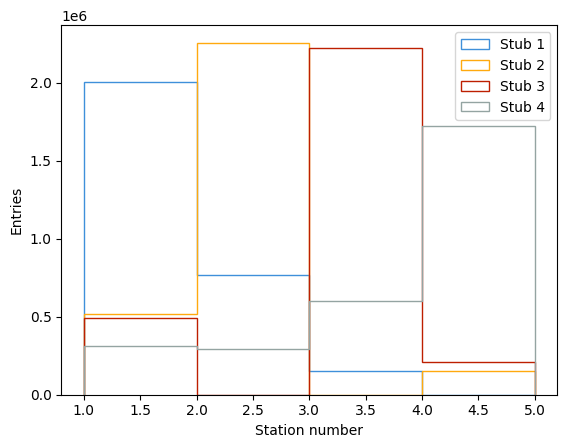

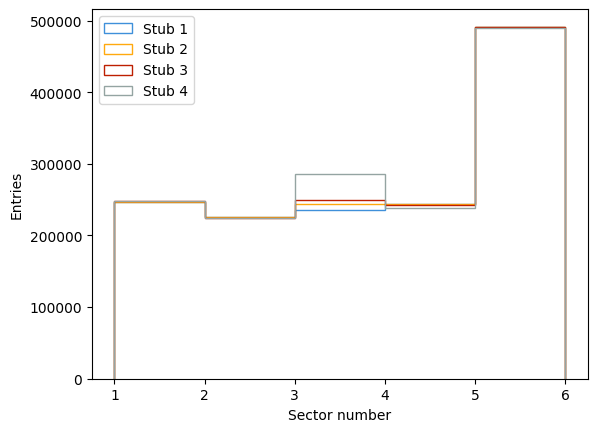

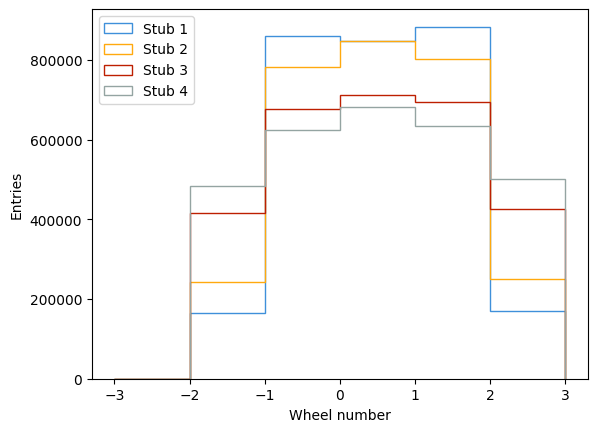

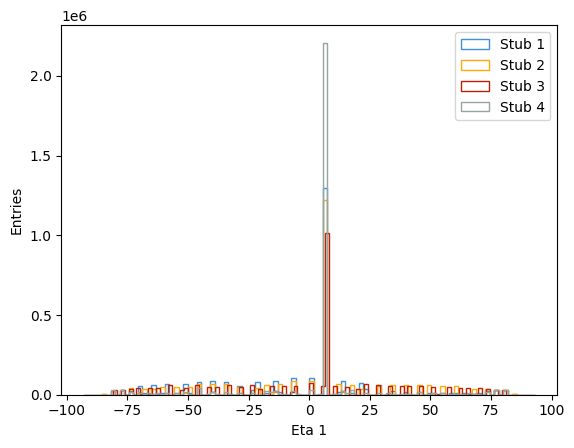

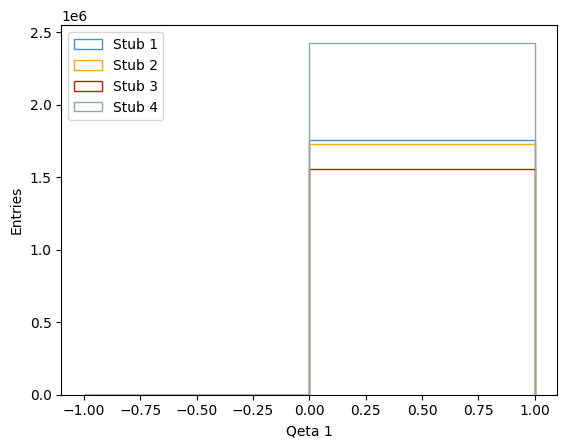

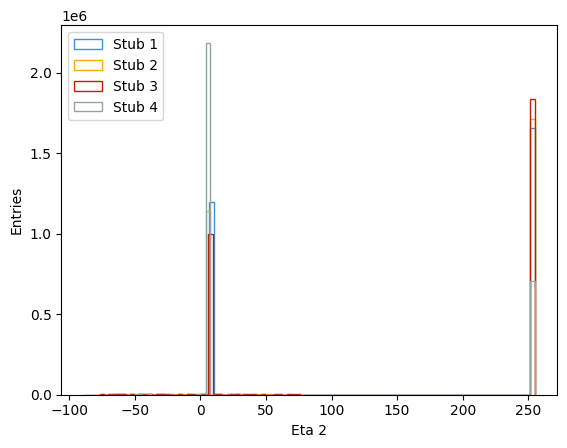

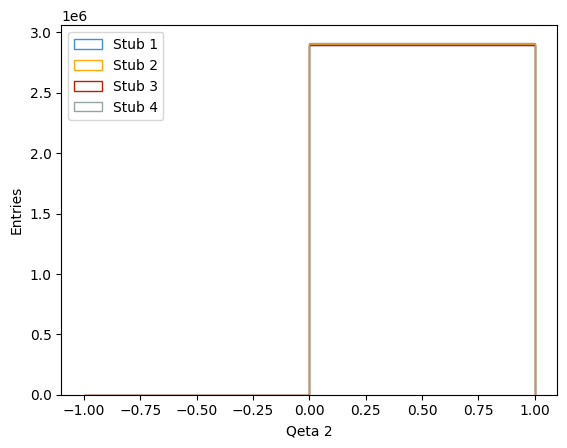

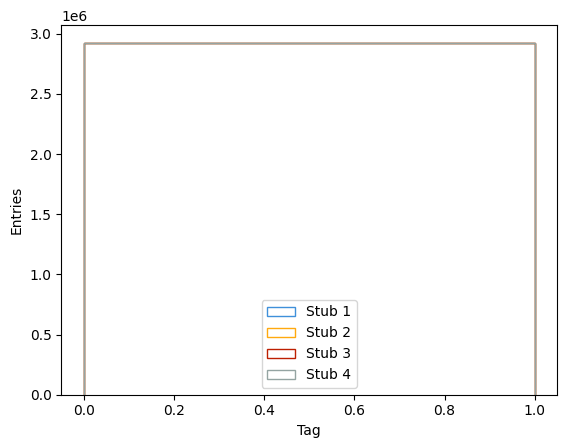

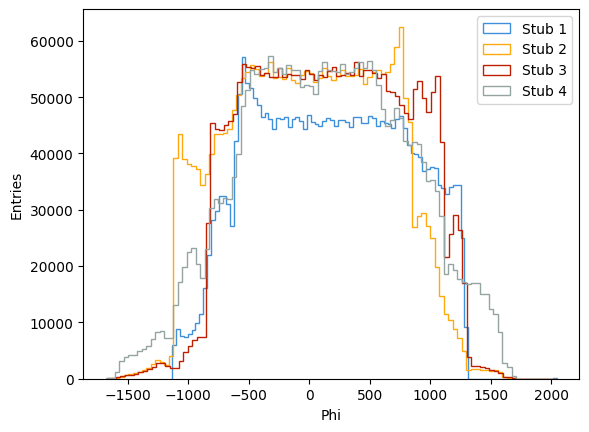

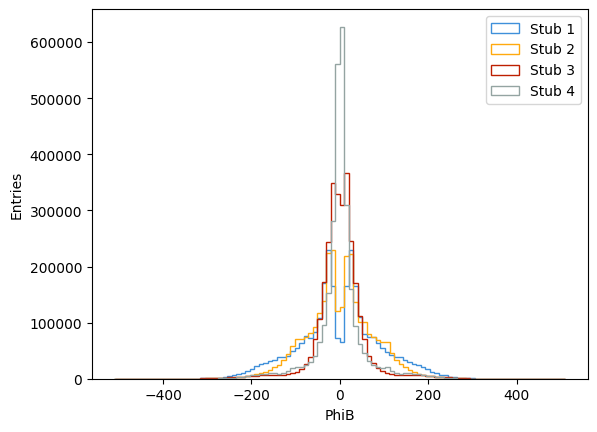

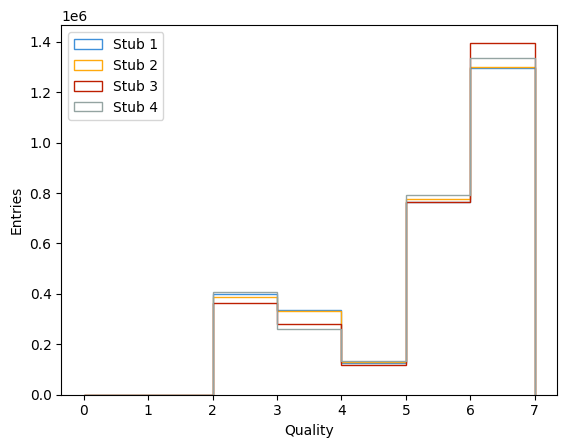

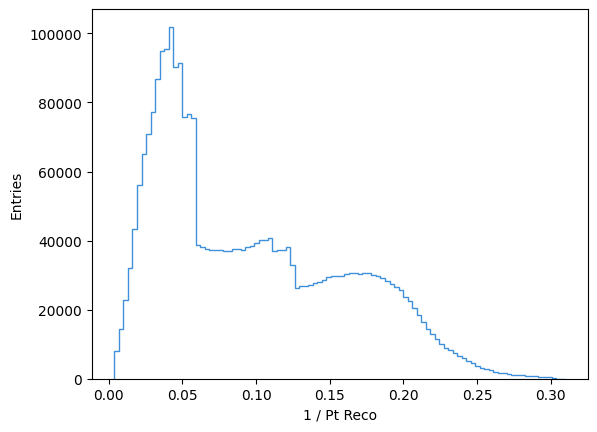

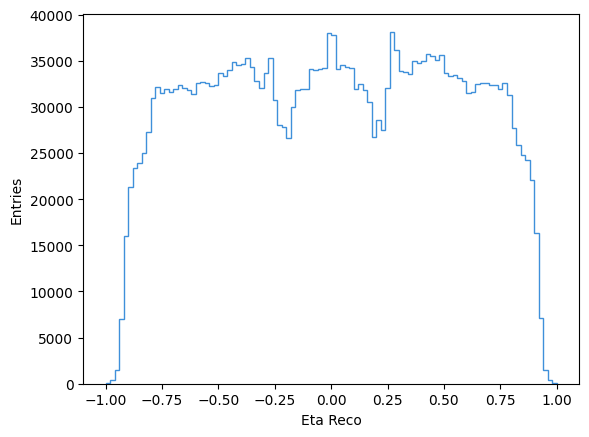

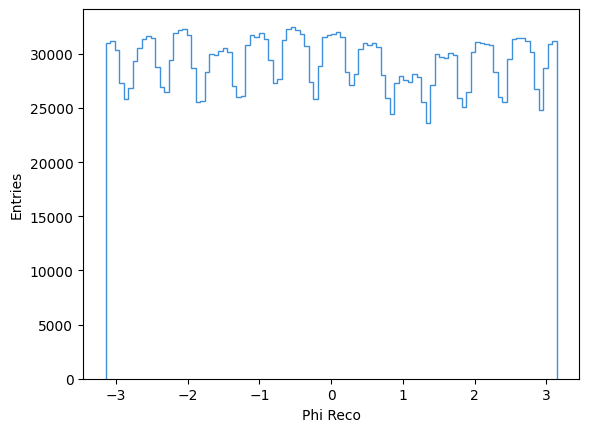

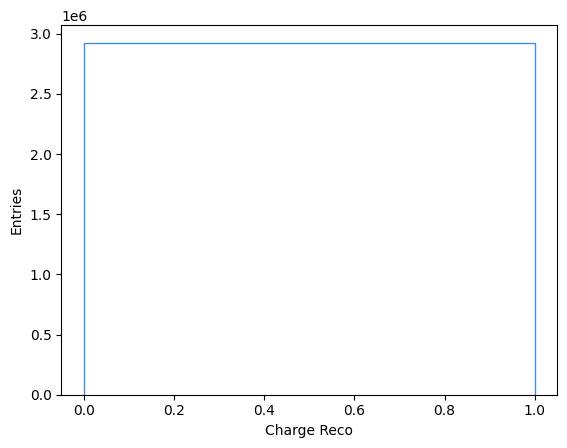

In [11]:
#stNum plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_stNum"].plot.hist(bins=range(1, 6), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Station number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/stNum.png")
plt.show()

#scNum plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_scNum"].plot.hist(bins=range(1, 7), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Sector number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/scNum.png")
plt.show()

#whNum plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_whNum"].plot.hist(bins=range(-3, 4), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Wheel number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/whNum.png")
plt.show()

#eta_1 plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_eta_1"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Eta 1")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/eta_1.png")
plt.show()


#qeta_1 plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_qeta_1"].plot.hist(bins=range(-1, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Qeta 1")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/qeta_1.png")
plt.show()

#eta_2 plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_eta_2"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Eta 2")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/eta_2.png")
plt.show()

#qeta_2 plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_qeta_2"].plot.hist(bins=range(-1, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Qeta 2")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/qeta_2.png")
plt.show()

#tag plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_tag"].plot.hist(bins=range(0, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Tag")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/tag.png")
plt.show()

#phi plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_phi"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Phi")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/phi.png")
plt.show()

#phiB plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_phiB"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("PhiB")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/phiB.png")
plt.show()

#quality plot
fig, ax = plt.subplots()
for i in range(1, 5):
    full_data[f"s{i}_quality"].plot.hist(bins=range(0, 8), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Quality")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/quality.png")
plt.show()


#ptRecoInverse plot
fig, ax = plt.subplots()
full_data["ptRecoInverse"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("1 / Pt Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/ptRecoInverse.png")
plt.show()

#etaExtRecoSt2 plot
fig, ax = plt.subplots()
full_data["etaExtRecoSt2"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("Eta Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/etaExtRecoSt2.png")
plt.show()

#phiExtRecoSt2 plot
fig, ax = plt.subplots()
full_data["phiExtRecoSt2"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("Phi Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/phiExtRecoSt2.png")
plt.show()

#chargeReco plot
fig, ax = plt.subplots()
full_data["chargeReco"].plot.hist(bins=range(0, 2), histtype='step', ax=ax)
ax.set_xlabel("Charge Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/chargeReco.png")
plt.show()

In [12]:
full_data

,n_stubs,s1_stNum,s1_scNum,s1_whNum,s1_eta_1,s1_qeta_1,s1_eta_2,s1_qeta_2,s1_tag,s1_phi,...,s4_phiB,s4_quality,ptRecoInverse,etaExtRecoSt2,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1
0,4,1,9,-1,-52,2,255,0,1,632,...,7,5,0.041279,-0.555335,-1.409220,0,29.0,-0.554625,-1.418080,1
2,3,1,5,1,7,0,7,0,1,10,...,12,2,0.052357,0.608174,2.628690,0,17.5,0.598125,2.628900,1
3,2,1,2,0,-14,2,-21,1,1,722,...,18,5,0.042819,-0.185071,1.230710,0,30.0,-0.184875,1.232640,1
4,4,1,9,-1,-46,2,255,0,1,140,...,9,6,0.058421,-0.485899,-1.515270,0,20.5,-0.467625,-1.527160,1
5,3,1,1,1,7,0,7,0,1,1202,...,-18,3,0.037988,0.738465,0.816011,0,31.0,0.750375,0.818123,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426409,3,1,6,1,7,0,7,0,1,1116,...,6,5,0.027158,0.750462,-2.863660,0,59.0,0.739500,-2.868880,1
3426410,2,3,9,2,74,2,255,0,1,908,...,-9,2,0.018035,0.790361,-1.350280,1,255.5,0.804750,-1.352630,0
3426411,4,1,7,-1,-40,2,255,0,1,-232,...,-9,6,0.052273,-0.436209,-2.690840,1,22.0,-0.424125,-2.694350,0
3426412,4,1,7,-1,-40,2,255,0,1,-232,...,-9,6,0.075172,-0.440287,-2.716570,1,22.0,-0.424125,-2.694350,0


In [13]:
train_val_data, test_data = train_test_split(full_data,      test_size=0.3, random_state=42)
train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

In [14]:
# inspect the datasets
print(f"Train dataset: {len(train_data)}")
print(f"Val dataset: {len(val_data)}")
print(f"Test dataset: {len(test_data)}")

Train dataset: 1843027
Val dataset: 204781
Test dataset: 877633


In [15]:
# normalize the data
for key in normalizations.keys():
    train_data[key] = train_data[key] / normalizations[key]
    val_data[key]   = val_data[key]   / normalizations[key]
    test_data[key]  = test_data[key]  / normalizations[key]

## NN Model

In [16]:
# Hyperparameters
input_size    = len(stub_features)
architecture  = [input_size, 64, 32, 16, 8]
output_size   = len(target_features)
learning_rate = 1e-2
num_epochs    = 300
batch_size    = 2**8
reg_strength  = 1e-3

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

# Early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10  # Number of epochs to wait before stopping
early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement

classification_weight = 1
regression_weight     = 6

# Loss and optimizer
# regression_criterion     = losses.MeanSquaredError()
classification_criterion = losses.BinaryCrossentropy(from_logits=True)
regression_criterion     = losses.MeanAbsoluteError()


optimizer = optimizers.Adam(learning_rate=learning_rate)
scheduler = CustomLRScheduler(
    optimizer, 
    factor=scale_factor, 
    patience=patience, 
    min_improvement=min_loss_improvement, 
    verbose=True
)

2024-07-08 14:58:00.632643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10518 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2024-07-08 14:58:00.633253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10532 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [17]:
# Groups the data into batches and shuffles them, and prefetches them to optimize performance
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features].values, val_data[target_features].values)).batch(batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features].values, test_data[target_features].values)).batch(batch_size)

In [18]:
# Create the model
model = MultiTaskNN(architecture, reg_strength=reg_strength)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model.build((bs, input_size))

# Print the number of parameters
total_params = model.count_params()
trainable_vars = [var for var in model.trainable_variables]
trainable_params = sum([tf.size(var).numpy() for var in trainable_vars])
print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 5724
Number of trainable parameters: 5724


In [19]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :-1] 
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regression_loss, classification_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :-1]
    classification_targets = targets[:, -1]
    reg_outputs, class_outputs = model(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    classification_loss = classification_criterion(classification_targets, class_outputs)
    loss = regression_weight * regression_loss + classification_weight * classification_loss
    return regression_loss, classification_loss, loss


## Train model

In [20]:
train_regression_losses     = []
train_classification_losses = []
train_combined_losses       = []
val_regression_losses       = []
val_classification_losses   = []
val_combined_losses         = []

learning_rates = []

out_file = open(os.path.join(OUT_PATH, LOSS_FNAME), "w")
out_file.write("train_regression_loss,train_classification_loss,train_combined_loss,val_regression_loss,val_classification_loss,val_combined_loss,learning_rate\n")


# Training loop
for epoch in range(num_epochs):
    # Training
    running_loss                = 0.0
    running_regression_loss     = 0.0
    running_classification_loss = 0.0
    
    # scheduler.on_epoch_begin(epoch, logs=None)
    
    for features, targets in train_dataset:
        
        regression_loss, classification_loss, loss = train_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
        running_classification_loss += classification_loss.numpy()
        
        # scheduler.on_batch_end(batch=None)
        
        # current_lr = optimizer.lr.numpy()
        
        # lr_per_batch.append(current_lr)
        # print(f"Learning rate: {current_lr:.2e}", end="\r")
        

        
    # Note: Remember to adjust if not using batches of equal sizes
    train_loss                = running_loss                / len(train_dataset)
    train_regression_loss     = running_regression_loss     / len(train_dataset)
    train_classification_loss = running_classification_loss / len(train_dataset)

    train_regression_losses.append(train_regression_loss)
    train_classification_losses.append(train_classification_loss)
    train_combined_losses.append(train_loss)

    # Validation
    running_loss                = 0.0
    running_regression_loss     = 0.0
    running_classification_loss = 0.0
    
    for features, targets in val_dataset:
        
        regression_loss, classification_loss, loss = val_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
        running_classification_loss += classification_loss.numpy()
    
    avg_val_loss                = running_loss                / len(val_dataset)
    avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
    avg_val_classification_loss = running_classification_loss / len(val_dataset)
        
    val_regression_losses.append(avg_val_regression_loss)
    val_classification_losses.append(avg_val_classification_loss)
    val_combined_losses.append(avg_val_loss)
    
    
    current_lr = optimizer.lr.numpy()
    learning_rates.append(current_lr)
    
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {current_lr:.2e}")
    print(f"Train Losses - Regression: {train_regression_losses[-1]:.4f}, Classification: {train_classification_losses[-1]:.4f}, Combined: {train_combined_losses[-1]:.4f}")
    print(f"Validation Losses - Regression: {val_regression_losses[-1]:.4f}, Classification: {val_classification_losses[-1]:.4f}, Combined: {val_combined_losses[-1]:.4f}")
    print("-------------")
    
    
    scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})


    with open(os.path.join(OUT_PATH, LOSS_FNAME), "a") as output_file:
        output_file.write(f"{train_regression_losses[-1]},{train_classification_losses[-1]},{train_combined_losses[-1]},{val_regression_losses[-1]},{val_classification_losses[-1]},{val_combined_losses[-1]},{current_lr}\n")

    # Check for early stopping based on the new criterion
    if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
        epochs_without_improvement = 0
        best_val_loss = min(best_val_loss, avg_val_loss)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs!")
        break

2024-07-08 14:58:07.640341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc94dcb3950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-08 14:58:07.640378: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-07-08 14:58:07.640387: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-07-08 14:58:07.646769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 14:58:07.668786: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1720443487.744910 3528808 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0280, Classification: 0.1433, Combined: 0.3112
Validation Losses - Regression: 0.0164, Classification: 0.1273, Combined: 0.2254
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0160, Classification: 0.1259, Combined: 0.2221
Validation Losses - Regression: 0.0147, Classification: 0.1288, Combined: 0.2169
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0151, Classification: 0.1233, Combined: 0.2137
Validation Losses - Regression: 0.0161, Classification: 0.1269, Combined: 0.2234
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0148, Classification: 0.1212, Combined: 0.2099
Validation Losses - Regression: 0.0140, Classification: 0.1221, Combined: 0.2061
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0146, Classification: 0.1199, Combined: 0.2072
Validation Losses - Regression: 0.0135, Classifica

### Predict the test data from `test_data`

In [21]:
test_features = test_data[stub_features].values
test_targets  = test_data[target_features].values

reg_predictions, class_predictions = model(test_features, training=False)

test_df = pd.DataFrame(
    np.concatenate(
        (
            test_features,
            test_targets,
            reg_predictions.numpy(),
            class_predictions.numpy(),
            test_data[l1_features].values,
        ),
        axis=1
    ),
    columns=stub_features + target_features + ["ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred", "chargeReco_pred"] + l1_features
)

test_df.loc[:, "chargeReco_pred"] = test_df["chargeReco_pred"].apply(lambda x: 1 / (1 + np.exp(-x)))
test_df.loc[:, "chargeReco_pred"] = test_df["chargeReco_pred"].apply(lambda x: 0 if x < 0.5 else 1)

# rescale the features
for key in normalizations.keys():
    test_df[key] = test_df[key] * normalizations[key]
    
# rescale the predictions
test_df["ptRecoInverse_pred"] = test_df["ptRecoInverse_pred"] * normalizations["ptRecoInverse"]
test_df["etaExtRecoSt2_pred"] = test_df["etaExtRecoSt2_pred"] * normalizations["etaExtRecoSt2"]
test_df["phiExtRecoSt2_pred"] = test_df["phiExtRecoSt2_pred"] * normalizations["phiExtRecoSt2"]
test_df["chargeReco_pred"]    = test_df["chargeReco_pred"]    * normalizations["chargeReco"]

# drop features keep only predictions and targets and L1 features
test_df = test_df[["ptRecoInverse", "etaExtRecoSt2", "phiExtRecoSt2", "chargeReco", "ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred", "chargeReco_pred"] + l1_features]

# create ptReco_true and etaReco_true and phiReco_true and chargeReco_true
# create ptReco_pred and etaReco_pred and phiReco_pred and chargeReco_pred
test_df["ptReco_true"]     = test_df["ptRecoInverse"].apply(lambda x: 1 / x)
test_df["etaReco_true"]    = test_df["etaExtRecoSt2"]
test_df["phiReco_true"]    = test_df["phiExtRecoSt2"]
test_df["chargeReco_true"] = test_df["chargeReco"]

test_df["ptReco_pred"]     = test_df["ptRecoInverse_pred"].apply(lambda x: 1 / x)
test_df["etaReco_pred"]    = test_df["etaExtRecoSt2_pred"]
test_df["phiReco_pred"]    = test_df["phiExtRecoSt2_pred"]
test_df["chargeReco_pred"] = test_df["chargeReco_pred"]

# transform hwSignL1 into chargeL1
test_df["chargeL1"] = test_df["hwSignL1"].apply(lambda x: 1 if x == 0 else 0)

# drop ptRecoInverse and etaExtRecoSt2 and phiExtRecoSt2 and chargeReco
# drop ptRecoInverse_pred and etaExtRecoSt2_pred and phiExtRecoSt2_pred and chargeReco_pred
test_df = test_df[["ptReco_true", "etaReco_true", "phiReco_true", "chargeReco_true", "ptReco_pred", "etaReco_pred", "phiReco_pred", "chargeReco_pred", "ptL1", "etaL1", "phiL1", "chargeL1"]]


test_df

,ptReco_true,etaReco_true,phiReco_true,chargeReco_true,ptReco_pred,etaReco_pred,phiReco_pred,chargeReco_pred,ptL1,etaL1,phiL1,chargeL1
0,7.14094,0.725395,1.863000,0.0,7.151509,0.718942,1.883688,0.0,9.0,0.750375,1.887140,0
1,22.94190,-0.825676,-2.726760,0.0,19.401611,-0.825460,-2.724575,0.0,27.0,-0.804750,-2.727080,0
2,77.79640,0.143982,-0.391065,0.0,60.780793,0.142775,-0.406932,0.0,93.5,0.141375,-0.414516,0
3,7.03724,0.803833,1.414660,0.0,7.563245,0.818913,1.398168,0.0,9.5,0.804750,1.396260,0
4,36.51210,-0.508647,-2.192450,1.0,32.377658,-0.504898,-2.193311,1.0,41.0,-0.478500,-2.192570,1
...,...,...,...,...,...,...,...,...,...,...,...,...
877628,4.12733,-0.517609,-0.834530,1.0,5.056474,-0.505164,-0.796669,1.0,8.5,-0.500250,-0.818123,1
877629,23.83930,0.883597,1.309400,1.0,20.724431,0.876612,1.312794,1.0,29.0,0.880875,1.309000,1
877630,6.30444,0.539451,2.764210,0.0,6.049547,0.506266,2.764828,0.0,8.5,0.500250,2.759800,0
877631,34.38710,-0.417246,3.093800,0.0,17.327510,-0.508267,3.089585,1.0,15.0,-0.511125,3.087050,1


In [22]:
accuracy = (test_df["chargeReco_pred"] == test_df["chargeReco_true"]).sum() / len(test_df)

print(f"Classification Accuracy on Test Set: {accuracy*100:.2f}%")

l1_accuracy = (test_df["chargeL1"] == test_df["chargeReco_true"]).sum() / len(test_df)

print(f"L1 Classification Accuracy on Test Set: {l1_accuracy*100:.2f}%")

Classification Accuracy on Test Set: 97.00%
L1 Classification Accuracy on Test Set: 97.28%


In [23]:
prob      = True
PLOT_PATH = f"/eos/user/{USER[0]}/{USER}/nnreco-plots/"
PLOT_FLAG = False

if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

### Resolution plots

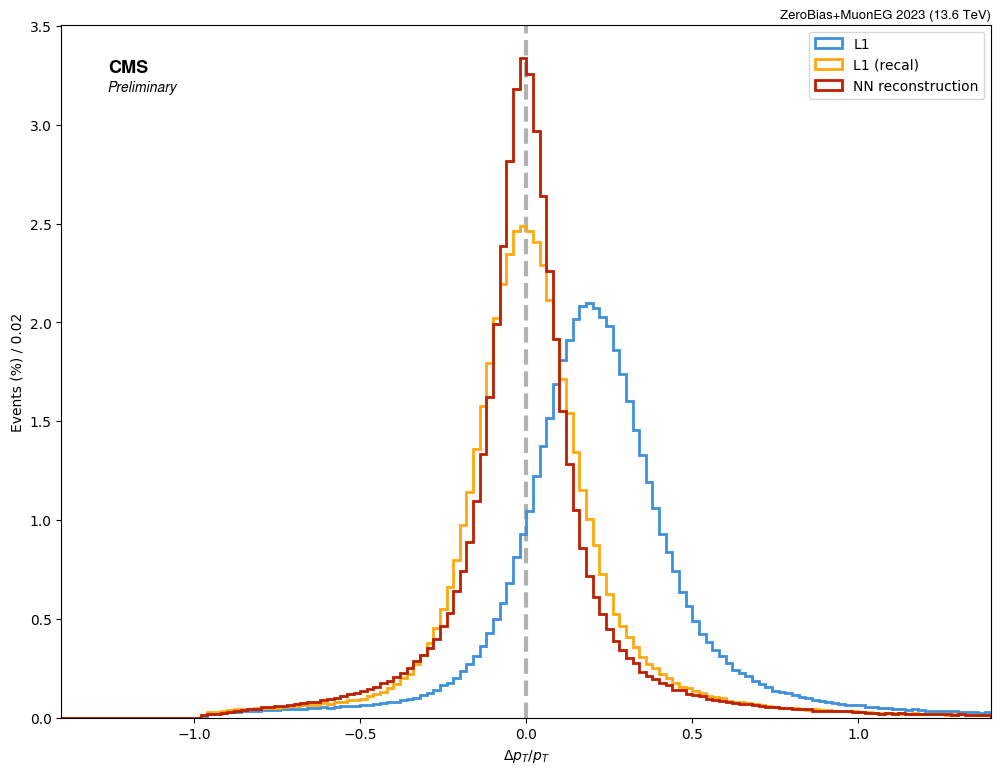

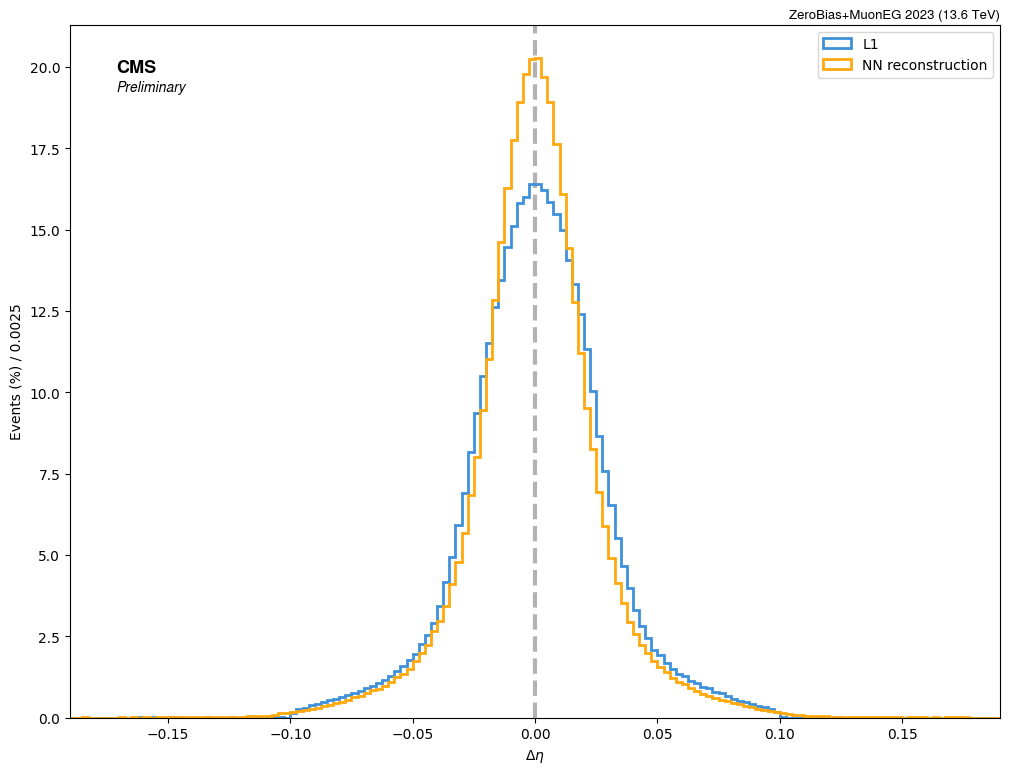

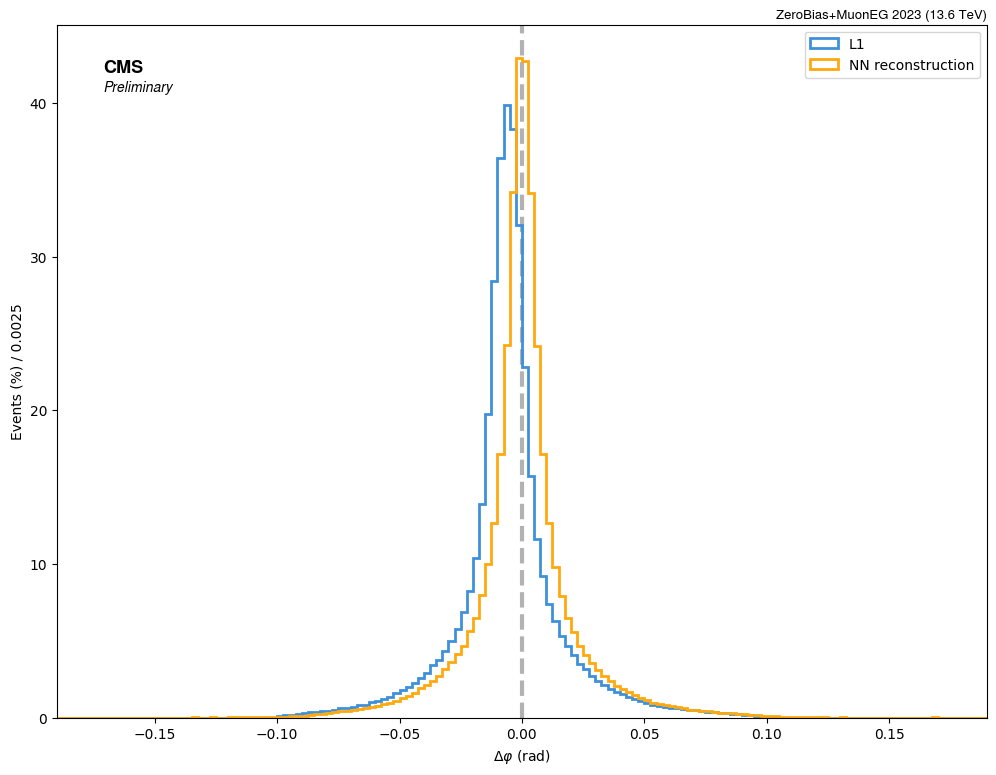

In [24]:
eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) / test_df.etaReco_true

# if eta_res_pred < -0.5 then add 1 to shift the histogram to the right
# mask = np.where(eta_res_pred < -0.5, 1, 0)
# eta_res_pred = eta_res_pred + mask

# recompute the predicted eta
# test_df["etaReco_pred"] = test_df.etaReco_true * (1 + eta_res_pred)

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1  - test_df.ptReco_true) / test_df.ptReco_true
pt_res_rec_l1   = (test_df.ptL1/1.2  - test_df.ptReco_true) / test_df.ptReco_true

eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) 
eta_res_l1   = (test_df.etaL1   - test_df.etaReco_true)

phi_res_pred = (test_df.phiReco_pred - test_df.phiReco_true)
phi_res_l1   = (test_df.phiL1   - test_df.phiReco_true)


rlabel = "ZeroBias+MuonEG 2023 (13.6 TeV)"

xmin = -1.4
xmax = 1.4
binw = 0.02

fig, ax = plt.subplots(1,1, figsize=(12,9))
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(pt_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(pt_res_rec_l1, bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1 (recal)")
plt.hist(pt_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta p_T / p_T$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/pt_res_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9))
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(eta_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(eta_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta \eta$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/eta_res_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9))
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(phi_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(phi_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta\\varphi$ (rad)")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/phi_res_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

### pT resolution vs pT perd true 2D histogram

In [25]:
heights.shape

NameError: name 'heights' is not defined

In [ ]:
xmin = 0
xmax = 50
xbinw = 0.5
ymin = -1.5
ymax = 1.5
ybinw = 0.02

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
heights, binsx, binsy = np.histogram2d(test_df.ptReco_true, pt_res_pred, bins=(np.arange(xmin, xmax+xbinw, xbinw), np.arange(ymin, ymax+ybinw, ybinw)))

fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(label="Preliminary", data=True, year=2023, rlabel=rlabel)

hep.hist2dplot(heights, binsx, binsy, ax=ax, cmap="viridis", flow=None, norm = mpl.colors.LogNorm())
cbar = ax.collections[0].colorbar
cbar.set_label("Events", labelpad=15) # , fontsize=36)
# cbar.ax.tick_params(labelsize=36)
# Adding labels and title
plt.xlabel("Reco muon $p_T$ (GeV)")
plt.ylabel("$\Delta p_T / p_T$")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_zoom{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

In [ ]:
xmin = 0
xmax = 50
binw = 0.5

# Compute pT resolution
pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1 / 1.2  - test_df.ptReco_true) / test_df.ptReco_true

# Define bins for pT reco true
pt_true_bins = np.arange(xmin, xmax+binw, binw)  # From 0 to 50 GeV with bin width 1 GeV

# Initialize arrays to store average pT resolution and standard deviation in each bin
avg_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
std_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
avg_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)
std_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)


# Loop through the bins to calculate average pT resolution and standard deviation
for i in range(len(pt_true_bins) - 1):
    lower_bound = pt_true_bins[i]
    upper_bound = pt_true_bins[i + 1]
    
    # Mask data points that fall within the current bin
    mask = (test_df.ptReco_true >= lower_bound) & (test_df.ptReco_true < upper_bound)
    
    # Compute the average pT resolution for the current bin
    avg_pt_res_pred[i] = np.mean(pt_res_pred[mask])
    avg_pt_res_l1[i]   = np.mean(pt_res_l1[mask])
    
    # Compute the standard deviation for the current bin
    std_pt_res_pred[i] = np.std(pt_res_pred[mask]) # / np.sqrt(len(pt_res_pred[mask]))
    std_pt_res_l1[i]   = np.std(pt_res_l1[mask])   # / np.sqrt(len(pt_res_l1[mask]))


# Create the profile plot
fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(ax=ax, data=True, year=2023, label="Preliminary", rlabel=rlabel)
plt.plot(pt_true_bins[:-1], avg_pt_res_l1, "-", label="L1", color="C0")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_l1 - std_pt_res_l1, avg_pt_res_l1 + std_pt_res_l1, alpha=0.3, color="C0")

plt.plot(pt_true_bins[:-1], avg_pt_res_pred, "-", label="NN", color="C1")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_pred - std_pt_res_pred, avg_pt_res_pred + std_pt_res_pred, alpha=0.3, color="C1")

ax.axhline(0, color="black", linestyle="--", linewidth=2, zorder=0)

# Plotting the average pT resolution with error bars

# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_l1, 
#     yerr=std_pt_res_l1, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="L1",
#     color=PALETTE[-1],
# )


# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_pred, 
#     yerr=std_pt_res_pred, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="NN Prediction",
#     color=PALETTE[0],
# )


# ax.legend(fontsize=36, loc="upper right")


# Adding labels and title
plt.xlabel("Reco muon $p_T$ [GeV]")
plt.ylabel("$\Delta p_T / p_T$")

# ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_profile{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.xlim(5,xmax)
plt.ylim(-2,2)
plt.legend()
plt.show()


In [ ]:
# plot losses
fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_regression_losses, label="Train")
ax.plot(val_regression_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_classification_losses, label="Train")
ax.plot(val_classification_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_combined_losses, label="Train")
ax.plot(val_combined_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}learning_rate{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}log_learning_rate{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

## Perform multiple trainings to compute average loss (TAKES A LOT OF TIME)

In [ ]:
N_ITER = 50

In [ ]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regression_loss, classification_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :-1]
    classification_targets = targets[:, -1]
    reg_outputs, class_outputs = model(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    classification_loss = classification_criterion(classification_targets, class_outputs)
    loss = regression_weight * regression_loss + classification_weight * classification_loss
    return regression_loss, classification_loss, loss

In [ ]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 50]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 50]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

In [ ]:
classification_criterion = losses.BinaryCrossentropy(from_logits=True)
regression_criterion     = losses.MeanAbsoluteError()

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

classification_weight = 1
regression_weight     = 5

In [ ]:
train_regression_losses_all     = []
train_classification_losses_all = []
train_combined_losses_all       = []
val_regression_losses_all       = []
val_classification_losses_all   = []
val_combined_losses_all         = []

for i in range(N_ITER):
    
    # Hyperparameters
    input_size    = len(stub_features)
    architecture  = [input_size, 64, 32, 16, 8]
    output_size   = len(target_features)
    learning_rate = 1e-2
    num_epochs    = 300
    batch_size    = 2**10
    reg_strength  = 1e-3

    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 10  # Number of epochs to wait before stopping
    early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement


    train_val_data, test_data = train_test_split(full_data,      test_size=0.3, random_state=42)
    train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

    # normalize the data
    for key in normalizations.keys():
        train_data[key] = train_data[key] / normalizations[key]
        val_data[key]   = val_data[key]   / normalizations[key]
        test_data[key]  = test_data[key]  / normalizations[key]
        
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
    val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features].values, val_data[target_features].values)).batch(batch_size)
    test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features].values, test_data[target_features].values)).batch(batch_size)


    # Create the model
    model = MultiTaskNN(architecture, reg_strength=reg_strength)

    # Build the model with the batch input shape
    bs = None  # None allows for variable batch size
    model.build((bs, input_size))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    scheduler = CustomLRScheduler(
        optimizer, 
        factor=scale_factor, 
        patience=patience, 
        min_improvement=min_loss_improvement, 
        verbose=True
    )


    train_regression_losses     = []
    train_classification_losses = []
    train_combined_losses       = []
    val_regression_losses       = []
    val_classification_losses   = []
    val_combined_losses         = []

    learning_rates = []
    
    @tf.function
    def train_step(features, targets):
        with tf.GradientTape() as tape:
            regression_targets = targets[:, :-1]
            classification_targets = targets[:, -1]
            reg_outputs, class_outputs = model(features, training=True)
            regression_loss = regression_criterion(regression_targets, reg_outputs)
            classification_loss = classification_criterion(classification_targets, class_outputs)
            loss = regression_weight * regression_loss + classification_weight * classification_loss

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return regression_loss, classification_loss, loss

    @tf.function
    def val_step(features, targets):
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=False)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss
        return regression_loss, classification_loss, loss


    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        
        for features, targets in train_dataset:
            
            regression_loss, classification_loss, loss = train_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()


            
        # Note: Remember to adjust if not using batches of equal sizes
        train_loss                = running_loss                / len(train_dataset)
        train_regression_loss     = running_regression_loss     / len(train_dataset)
        train_classification_loss = running_classification_loss / len(train_dataset)

        train_regression_losses.append(train_regression_loss)
        train_classification_losses.append(train_classification_loss)
        train_combined_losses.append(train_loss)

        # Validation
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        for features, targets in val_dataset:
            
            regression_loss, classification_loss, loss = val_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()
        
        avg_val_loss                = running_loss                / len(val_dataset)
        avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        avg_val_classification_loss = running_classification_loss / len(val_dataset)
            
        val_regression_losses.append(avg_val_regression_loss)
        val_classification_losses.append(avg_val_classification_loss)
        val_combined_losses.append(avg_val_loss)
        
        
        current_lr = optimizer.lr.numpy()
        learning_rates.append(current_lr)
        
        
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Learning rate: {current_lr:.2e}")
        print(f"Train Losses - Regression: {train_regression_losses[-1]:.4f}, Classification: {train_classification_losses[-1]:.4f}, Combined: {train_combined_losses[-1]:.4f}")
        print(f"Validation Losses - Regression: {val_regression_losses[-1]:.4f}, Classification: {val_classification_losses[-1]:.4f}, Combined: {val_combined_losses[-1]:.4f}")
        print("-------------")
        
        
        scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})

        

        # Check for early stopping based on the new criterion
        if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
            epochs_without_improvement = 0
            best_val_loss = min(best_val_loss, avg_val_loss)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
        
    train_regression_losses_all.append(train_regression_losses)
    train_classification_losses_all.append(train_classification_losses)
    train_combined_losses_all.append(train_combined_losses)
    val_regression_losses_all.append(val_regression_losses)
    val_classification_losses_all.append(val_classification_losses)
    val_combined_losses_all.append(val_combined_losses)
    
    del model
    del optimizer
    del scheduler
    del train_dataset
    del val_dataset
    del test_dataset
    del train_data
    del val_data
    del test_data
    del train_val_data

In [ ]:
# compute the mean and std of the losses for each epoch
# the lists in the lists are of different lengths, so we need to pad them with the last value
# then we can compute the mean and std

train_regression_losses_all      = [x + [x[-1]] * (max(map(len, train_regression_losses_all)) - len(x)) for x in train_regression_losses_all]
train_classification_losses_all  = [x + [x[-1]] * (max(map(len, train_classification_losses_all)) - len(x)) for x in train_classification_losses_all]
train_combined_losses_all        = [x + [x[-1]] * (max(map(len, train_combined_losses_all)) - len(x)) for x in train_combined_losses_all]

val_regression_losses_all        = [x + [x[-1]] * (max(map(len, val_regression_losses_all)) - len(x)) for x in val_regression_losses_all]
val_classification_losses_all    = [x + [x[-1]] * (max(map(len, val_classification_losses_all)) - len(x)) for x in val_classification_losses_all]
val_combined_losses_all          = [x + [x[-1]] * (max(map(len, val_combined_losses_all)) - len(x)) for x in val_combined_losses_all]

train_regression_losses_mean     = np.mean(np.array(train_regression_losses_all), axis=0)[1:]
train_regression_losses_std      = np.std(np.array(train_regression_losses_all), axis=0)[1:]
train_classification_losses_mean = np.mean(np.array(train_classification_losses_all), axis=0)[1:]
train_classification_losses_std  = np.std(np.array(train_classification_losses_all), axis=0)[1:]
train_combined_losses_mean       = np.mean(np.array(train_combined_losses_all), axis=0)[1:]
train_combined_losses_std        = np.std(np.array(train_combined_losses_all), axis=0)[1:]

val_regression_losses_mean       = np.mean(np.array(val_regression_losses_all), axis=0)[1:]
val_regression_losses_std        = np.std(np.array(val_regression_losses_all), axis=0)[1:]
val_classification_losses_mean   = np.mean(np.array(val_classification_losses_all), axis=0)[1:]
val_classification_losses_std    = np.std(np.array(val_classification_losses_all), axis=0)[1:]
val_combined_losses_mean         = np.mean(np.array(val_combined_losses_all), axis=0)[1:]
val_combined_losses_std          = np.std(np.array(val_combined_losses_all), axis=0)[1:]

In [ ]:


# REGRESSION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_regression_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_regression_losses_mean)), train_regression_losses_mean - train_regression_losses_std, train_regression_losses_mean + train_regression_losses_std, alpha=0.3)
ax.plot(val_regression_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_regression_losses_mean)), val_regression_losses_mean - val_regression_losses_std, val_regression_losses_mean + val_regression_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}regression_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# CLASSIFICATION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_classification_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_classification_losses_mean)), train_classification_losses_mean - train_classification_losses_std, train_classification_losses_mean + train_classification_losses_std, alpha=0.3)
ax.plot(val_classification_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_classification_losses_mean)), val_classification_losses_mean - val_classification_losses_std, val_classification_losses_mean + val_classification_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}classification_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# COMBINED LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_combined_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_combined_losses_mean)), train_combined_losses_mean - train_combined_losses_std, train_combined_losses_mean + train_combined_losses_std, alpha=0.3)
ax.plot(val_combined_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_combined_losses_mean)), val_combined_losses_mean - val_combined_losses_std, val_combined_losses_mean + val_combined_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}combined_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()